# Homework 4: DQN and Double DQN

## Due: 23:59:59 (GMT +08:00), May 2, 2024

In this part, we will implement two algorithms in a Pendulum-v1 environment.

You are required to finish <u>*several*</u> coding exercises and answer <u>*several*</u> questions in the following notebook.

## Environment Setting

This environment is part of the classic control environments. The system in this environment consists of a pendulum attached at one end to a fixed point and the other end being free. The pendulum begins in a random position and the objective is to apply torque to the free end to swing it into an upright position. When the pendulum is upright upwards, a reward of $0$ is given, while being in other positions yields a negative reward. The environment itself has no termination state but the episode truncates at 200 steps.

In this environment, the observation is an `ndarray` with shape `(3,)` representing the x-y coordinates of the pendulum’s free end and its angular velocity.

Num | Observation  | min | max
----|--------------|-----|----
0   | $\cos \theta$| -1.0| 1.0
1   | $\sin \theta$| -1.0| 1.0
2   | $\dot\theta$ | -8.0| 8.0

The vanilla action space in the environment is continuous, where each action is an `ndarray` with shape `(1,)`, representing the torque applied to free end of the pendulum. To apply value-based methods in this environment, we further discretize the action space into a discrete one, where there are $11$ actions and each discrete action $a \in \{ 0,1,\dots,10 \}$ represents torque $0.4 \times a − 2$. You can refer to the website for more detailed information about this environment.

Num | Action  | min | max
----|---------|-----|----
0   | Torque  | -2.0| 2.0

![Pendulum](https://cdn.kesci.com/upload/image/qfoepa3n0z.gif?imageView2/0/w/960/h/960)

In [13]:
import math
import random
from collections import deque

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn, optim

## DQN and Double DQN Algorithm

The optimization function of traditional **DQN** is 
$$
r+\gamma \max _{a^{\prime}} Q_{\theta^-}\left(s', a^{\prime}\right)
$$

This value is computed by target agent $\theta^-$, It can be shown in following formula
$$
Q_{\theta^-}\left(s', \arg\max_{a'} Q_{\theta^-}\left(s',  a' \right) \right)
$$

In other words, the $\max$ operation can actually be broken down into two steps, first selecting the optimal action at state $s'$: $a^{*} = \arg\max_{a'} Q_{\theta^-}\left(s', a' \right)$ and then compute the relevant Q-value $Q\left(s', a^* \right)$. When these two steps are calculated using the same Q network, each time the obtained is the maximum of all Q values currently estimated by the agent $\theta^-$. DQN always overestimated the $Q$ value function and the error will cumulate.

To solve this problem, **Double DQN** is proposed to estimate $\max_{a'} Q_*(s', a')$ with two independently trained neural networks. The approach is to change original function $\max _{a'} Q_{\theta^-}\left(s', a'\right)$ to 
$$
Q_{\theta^-}\left(s', \arg\max_{a'} Q_{\theta}\left(s',  a' \right) \right)
$$

We use one of the neural networks $Q_{\boldsymbol{\theta}}$ to select an action, and another one $Q_{\boldsymbol{\theta}^{-}}$ to calculate the Q value of the action. In this way, even if the Q-value is overestimated by one network, due to the existence of another one, the final Q value used by this action will not be greatly overestimated, which solves the problem to a certain extent.

In this section, we will try to implement DQN and Double DQN. The implementation of the algorithm is divided into three parts: (1) DQN-base network; (2) Replay buffer; (3) Learning function. You may refer to [1] and [2] for the algorithmic details of DQN and Double DQN, respectively.

### DQN Base Network

Our agent is a three-layer MLP, which takes in a vector shape like `(state_dim, )`, and outputs a Q-value vector $Q$ with a shape like `(action_num, )`, where the $i$-th dim of $Q$ means $Q(s,a_{i})$.

In [14]:
class DQN_base(nn.Module):
    def __init__(self):
        super(DQN_base, self).__init__()

    def forward(self, x):
        raise NotImplementedError

    def act(self, state, epsilon, device, discrete_action_n):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
                q_value = self.forward(state)
                action = q_value.max(1).indices.item()
        else:
            action = random.randrange(discrete_action_n)
        return action

In [15]:
class DQN(DQN_base):
    def __init__(self, input_n, num_actions, h_size=24):
        super(DQN, self).__init__()
        self.input_n = input_n
        self.num_actions = num_actions
        self.fc = nn.Sequential(
            nn.Linear(self.input_n, h_size),
            nn.ReLU(),
            nn.Linear(h_size, h_size),
            nn.ReLU(),
            nn.Linear(h_size, self.num_actions)
        )

    def forward(self, x):
        return self.fc(x)

### Replay Buffer
**Coding exercises.**

This part you are required to implement: (a) the push operation of one sample in function `push()`; (b) the sample operation of a batch of samples in function `sample()`.


In [16]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def push(self, state, action, reward, next_state, done):
        """
        Args:
            state (ndarray (3,)),
            action (int),
            reward (float),
            next_state (ndarray (3,)),
            done (bool)
        Return:
            None
        """
        # Programming 1: implement the push operation of one sample
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Args:
            batch_size (int)
        Return:
            a batch of states (ndarray, (batch_size, state_dimension)),
            a batch of actions (list or tuple, length=batch_size),
            a batch of rewards (list or tuple, length=batch_size),
            a batch of next-states (ndarray, (batch_size, state_dimension)),
            a batch of done flags (list or tuple, length=batch_size)
        """
        # Programming 2: implement the sample operation of a batch of samples
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return np.array(states), actions, rewards, np.array(next_states), dones

### Learning Function and Training Loop

**Coding exercises.**

This part you are required to implement: (a) the computation of the Q values of next-states for Double DQN; (b) the computation of the Q values of next-states for vanilla DQN; (c) the computation of the expected Q values of current states; (d) the computation of the TD loss in function `learn()`.

You are require to run the following block without editting any hyperparameter. **Your output will be one of the criteria we use to score**.

100%|██████████| 30000/30000 [01:27<00:00, 342.72it/s]


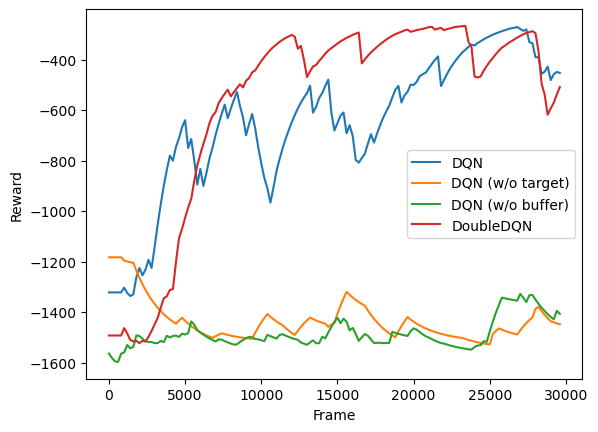

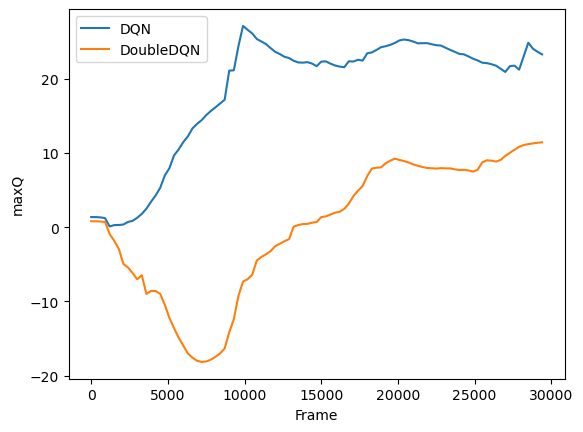

In [18]:
def learn(batch_size, current_model, target_model, replay_buffer, optimizer):
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    with torch.no_grad():
        states = torch.FloatTensor(np.float32(states)).to(device)
        next_states = torch.FloatTensor(np.float32(next_states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)
    q_values = current_model(states)
    next_q_values = current_model(next_states)
    if USE_TARGET_NET:
        next_q_values_target = target_model(next_states)
    q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    if USE_DOUBLE_Q:
        # Programming 3: complete the computation of the Q values of next states for double DQN
        max_actions = torch.max(next_q_values, 1)[1].unsqueeze(1)
        max_next_q_values = next_q_values_target.gather(1, max_actions).squeeze(1)
    else:
        if USE_TARGET_NET:
            # Programming 4: complete the computation of the Q values of next states for vanilla DQN
            max_next_q_values = torch.max(next_q_values_target, 1)[0]
        else:
            max_next_q_values = torch.max(next_q_values, 1)[0]
    # Programming 5: complete the computation of the expected Q values of current states
    q_targets = rewards + gamma * max_next_q_values * (1 - dones)
    # Programming 6: complete the computation of the TD loss
    loss = torch.mean(F.mse_loss(q_values, q_targets))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def set_env(env_id):
    global env, env1, discrete_action_n, input_n, faction
    env = gym.make(env_id)
    env1 = gym.make(env_id)
    input_n = env.observation_space.shape[0]
    if not isinstance(env.action_space, gym.spaces.discrete.Discrete):
        discrete_action_n = 11
        action_lowbound = env.action_space.low[0]
        action_upbound = env.action_space.high[0]
        def faction(discrete_n):
            return action_lowbound + (discrete_n / (discrete_action_n - 1)) * (action_upbound - action_lowbound)
    else:
        discrete_action_n = env.action_space.n

def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

def smooth_curve(y, smooth):
    length = int(np.prod(y.shape))
    for i in range(1, length):
        if not np.isinf(y[i - 1]) and not np.isnan(y[i - 1]):
            y[i] = smooth * y[i - 1] + (1 - smooth) * y[i]
    return y

def moving_average(y, x=None, total_steps=100, smooth=0.9, move_max=False):
    if isinstance(y, list):
        y = np.array(y)
    length = int(np.prod(y.shape))
    if x is None:
        x = list(range(1, length + 1))
    if isinstance(x, list):
        x = np.array(x)
    if length > total_steps:
        block_size = length // total_steps
        select_list = list(range(0, length, block_size))[:-1]
        y = y[:len(select_list) * block_size].reshape(-1, block_size)
        y = np.max(y, -1) if move_max else np.mean(y, -1)
        x = x[select_list]
    y = smooth_curve(y, smooth)
    return y, x

def compareResult(rewards, labels, use_max=False, smooth=0.9, ylabel_name="Reward"):
    plt.clf()
    plt.ylabel(ylabel_name)
    plt.xlabel("Frame")
    for rs in rewards:
        x1 = None if use_max else list(range(0, len(rs)*eval_step, eval_step))
        reward1, x1 = moving_average(rs, x1, move_max=use_max, smooth=smooth)
        plt.plot(x1, reward1)
    plt.legend(labels)
    plt.show()

def evaluation(current_model):
    state = env1.reset(seed=SEED)[0]
    done = False
    result = 0
    while not done:
        action = current_model.act(state, 0, device, discrete_action_n)
        if not isinstance(env.action_space, gym.spaces.discrete.Discrete):
            next_state, reward, done1, done2, _ = env1.step(np.array([faction(action)]))
        else:
            next_state, reward, done1, done2, _ = env1.step(action)
        done = done1 or done2
        state = next_state
        result += reward
    return result

def train(num_frames, DQN=None):
    def maxQ(model, state):
        with torch.no_grad():
            state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
            q_value = model(state)
            max_q_value = q_value.max(1).values.item()
        return max_q_value
    replay_buffer = ReplayBuffer(replay_buffer_size)
    current_model = DQN(input_n, discrete_action_n, h_size=h_size).to(device)
    target_model = None
    if USE_TARGET_NET:
        target_model = DQN(input_n, discrete_action_n, h_size=h_size).to(device)
        update_target(current_model, target_model)
    optimizer = optim.Adam(current_model.parameters(), lr=learning_rate)
    max_Qs = []
    now_Q = 0
    all_rewards = []
    episode_reward = 0
    episode = 0
    state = env.reset(seed=SEED)[0]
    for frame_idx in tqdm(range(1, num_frames + 1)):
        epsilon = epsilon_by_frame(frame_idx)
        action = current_model.act(state, epsilon, device, discrete_action_n)
        now_Q = maxQ(current_model, state) 
        max_Qs.append(now_Q)
        if not isinstance(env.action_space, gym.spaces.discrete.Discrete):
            next_state, reward, done1, done2,_ = env.step(np.array([faction(action)]))
        else:
            next_state, reward, done1, done2,_ = env.step(action)
        done = done1 or done2
        replay_buffer.push(state, action, reward, next_state, done)
        episode_reward += reward
        state = next_state
        if done:
            state = env.reset()[0]
            episode_reward = 0
            episode += 1
        if frame_idx % eval_step == 0:
            r = evaluation(current_model)
            all_rewards.append(r)
        if len(replay_buffer) >= replay_initial:
            learn(batch_size, current_model, target_model, replay_buffer, optimizer)
        if frame_idx % update_target_step == 0 and USE_TARGET_NET:
            update_target(current_model, target_model)
    return max_Qs, all_rewards

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 9
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
gamma = 0.98
env, env1 = None, None
discrete_action_n, input_n = 0, 0
faction = None
ENV_NAME = "Pendulum-v1"
set_env(ENV_NAME)
num_frames = 30000
epsilon_start = 0.5
epsilon_final = 0.01
epsilon_decay = 1500
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
update_target_step = 100
learning_rate = 0.01
eval_step = 200
h_size=24
algo_list = ['DQN', 'DQN (w/o target)', 'DQN (w/o buffer)', 'DoubleDQN']
return_list = []
maxQ_list = []
for ALGO  in algo_list:
    if ALGO == 'DQN': # vanilla DQN
        USE_REPLAY_BUFFER = True
        USE_TARGET_NET = True
        USE_DOUBLE_Q = False
    elif ALGO == 'DQN (w/o target)': # DQN w/o target network
        USE_REPLAY_BUFFER = True
        USE_TARGET_NET = False
        USE_DOUBLE_Q = False
    elif ALGO == 'DQN (w/o buffer)': # DQN w/o replay buffer
        USE_REPLAY_BUFFER = False
        USE_TARGET_NET = True
        USE_DOUBLE_Q = False
    elif ALGO == 'DoubleDQN': # double DQN
        USE_REPLAY_BUFFER = True
        USE_TARGET_NET = True
        USE_DOUBLE_Q = True
    replay_initial = 1000 if USE_REPLAY_BUFFER else 1
    replay_buffer_size = 3000 if USE_REPLAY_BUFFER else 1
    batch_size = 64 if USE_REPLAY_BUFFER else 1
    maxQ_value, episode_return = train(num_frames, DQN=DQN)
    maxQ_list.append(maxQ_value)
    return_list.append(episode_return)
compareResult(return_list, algo_list)
compareResult([maxQ_list[0], maxQ_list[3]], [algo_list[0], algo_list[3]], use_max=True, ylabel_name="maxQ")

**Questions.**

* Compare the performance difference between vanilla DQN and DQN without using the target network. Discuss the reason for this difference.
  * We can see that vanilla DQN achieves a satisfactory performance, while DQN without using the target network fails to learn a successful policy.
  * The performance gap comes from the lack of target network. Note that the TD target itself contains the output of the Q network, so the TD target is changing as the Q network is updated, which makes training unstable and leads to divergence. The target network decouples the computation of the TD target from training the Q network, which stabilizes the training process.
* Compare the performance difference between vanilla DQN and DQN without using the replay buffer. Discuss the reason for this difference.
  * We can see that vanilla DQN achieves a satisfactory performance, while DQN without using the replay buffer fails to learn a successful policy.
  * The performance gap comes from the lack of replay buffer. The replay buffer stores the transitions in the past, which breaks the temporal correlation between the samples and improves the sample efficiency. In addition, DQN without replay buffer only uses one sample to update the Q network each step, which makes the gradient estimation inaccurate and leads to divergence.
* Compare the performance difference and estimated maximum Q-value between vanilla DQN and Double DQN. Discuss the reason for this difference.
  * We can see that vanilla DQN achieves a similar performance to Double DQN. However, Double DQN converges significantly faster than vanilla DQN.
  * The performance gap comes from the overestimation of Q values. Vanilla DQN always selects the action with the maximum Q value. However, the Q network accumulates errors during training, which leads to overestimation of Q values. Double DQN uses two separate Q networks to estimate the maximum Q value, where one network is used to select the action and the other is used to calculate the Q value of the action, so the overestimation of Q values is alleviated to a certain extent.

## Reference
[1] Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Andrei A. Rusu, Joel Veness, Marc G. Bellemare,
Alex Graves, Martin A. Riedmiller, Andreas Fidjeland, Georg Ostrovski, Stig Petersen, Charles Beattie,
Amir Sadik, Ioannis Antonoglou, Helen King, Dharshan Kumaran, Daan Wierstra, Shane Legg, and
Demis Hassabis. Human-level control through deep reinforcement learning. Nat., 518(7540):529–533,
2015. URL https://doi.org/10.1038/nature14236.

[2] Hado van Hasselt, Arthur Guez, and David Silver. Deep reinforcement learning with double q-learning.
In Dale Schuurmans and Michael P. Wellman, editors, Proceedings of the Thirtieth AAAI Conference
on Artificial Intelligence, February 12-17, 2016, Phoenix, Arizona, USA, pages 2094–2100. AAAI Press,
2016. URL http://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389.